# lorapy data processing

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
OTA_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_OTA')
OUTDOOR_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_Outdoor')
DOTP_DATA_DIR = _BASE_DATA_DIR.joinpath('symbol-ref')

## utils

In [4]:
import random
rand = lambda mx: random.randint(0, mx)

# load

## dat files

In [5]:
loader = lorapy.load_dat(BENCHTOP_DATA_DIR, autoload=True)
loader.filter(bw=9, sf=10)

2020-04-07 16:39:49.002 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/lora-benchtop-recording
2020-04-07 16:39:49.015 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 110 data file(s)


[DatFile(id=89 | name='lora_BW9_SF10_915MHz_20ksps_Att60_v0.dat'),
 DatFile(id=94 | name='lora_BW9_SF10_915MHz_20ksps_Att120_v0.dat'),
 DatFile(id=96 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.dat'),
 DatFile(id=97 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.dat'),
 DatFile(id=100 | name='lora_BW9_SF10_915MHz_20ksps_Att40_v0.dat'),
 DatFile(id=101 | name='lora_BW9_SF10_915MHz_20ksps_Att80_v0.dat'),
 DatFile(id=107 | name='lora_BW9_SF10_915MHz_20ksps_Att20_v0.dat')]

In [6]:
file = loader.select(96)
file

DatFile(id=96 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.dat')

## dotp files

In [8]:
ploader = lorapy.load_dotp(DOTP_DATA_DIR)
ploader.filter(bw=9, sf=10)

2020-04-07 16:40:12.491 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/symbol-ref
2020-04-07 16:40:12.493 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 15 data file(s)


[DotPFile(id=1 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p')]

In [9]:
pfile = ploader.select(1)
pfile

DotPFile(id=1 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p')

# process

## convert 

In [10]:
signal = file.to_signal()
signal

2020-04-07 16:40:22.607 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-07 16:40:22.710 | INFO     | lorapy.datafile._base_file:load:61 - loaded 15036416 samples from file


LoraSignal(length=15036416) | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

In [11]:
base_symbol = pfile.to_signal()
base_symbol

2020-04-07 16:40:22.840 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-07 16:40:22.846 | INFO     | lorapy.datafile._base_file:load:61 - loaded 399 samples from file


BaselineSymbolSet(num symbols=399 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

## stats 

In [12]:
signal.stats

BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

In [13]:
base_symbol.stats

BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

## plots

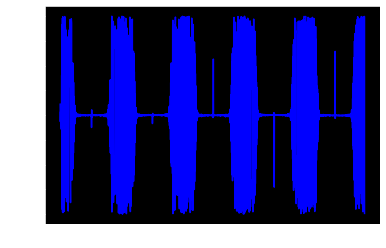

In [16]:
signal.plot(real=False, stop=2_000, color='blue')

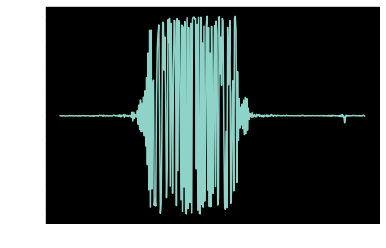

In [15]:
plt.plot(base_symbol.data)

# packets

## extract - auto adjust

## extract - manual adjust

In [17]:
signal.extract_packets(method='slide-mean', auto_adj=False, overlap=0.7)

2020-04-07 16:40:48.012 | INFO     | lorapy.signals.signal:_process_signal:106 - selected "slide-mean" processing method
2020-04-07 16:40:48.059 | INFO     | lorapy.signals.processing.sliding_mean:_find_all_mindices:55 - scanning signal for padding locations..
2020-04-07 16:40:48.060 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 0
2020-04-07 16:40:48.084 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 100
2020-04-07 16:40:48.108 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 200
2020-04-07 16:40:48.135 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 300
2020-04-07 16:40:48.155 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 400
2020-04-07 16:40:48.176 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 500
2020-04-07 16:40:48.194 | DEBUG    | lorapy.signals.proce

In [90]:
signal.adjust_packets(force_check=True, look_ahead=100, threshold=0.5)

2020-04-07 16:48:39.645 | DEBUG    | lorapy.signals.signal:_adjust_endpoints:86 - adjusted endpoints
2020-04-07 16:48:39.646 | DEBUG    | lorapy.packets.utils:slice_all_packets:21 - got max packet length: 12100
2020-04-07 16:48:39.751 | INFO     | lorapy.packets.utils:slice_all_packets:28 - extracted 1105 packets from signal
2020-04-07 16:48:39.760 | DEBUG    | lorapy.signals.signal:_slice_and_load:62 - loaded 1105 lora packets


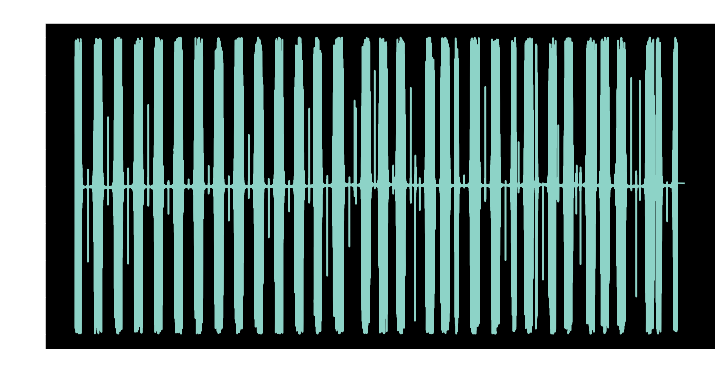

In [140]:
plt.figure(figsize=(12,6))
signal.plot_packet()

In [100]:
packet = signal.packets[1090]
packet

LoraPacket(id=1090) || size: 12100 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

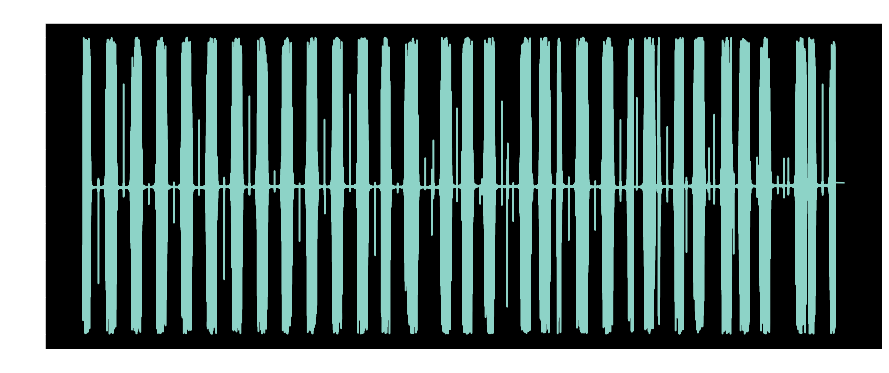

In [101]:
plt.figure(figsize=(15,6))
packet.plot(real=False)

## np correlate

In [238]:
import scipy as sp
import scipy.signal as sp_sig

from lorapy.symbols.baseline import BaselineSymbolSet
from lorapy.packets.packet import LoraPacket

### functionized

In [236]:
def _create_shifts(samples_per_sym: int, range_factor: int=10, step: int=2):
    return range(0, int(samples_per_sym * range_factor), step)

shifts = _create_shifts(signal.stats.samp_per_sym, range_factor=10, step=2)
shifts

def _compute_corrcoefs(base_symbol: np.ndarray, packet_slice: np.ndarray):
    return np.real(np.abs(
        np.corrcoef(base_symbol, packet_slice)[0,1]
    ))

_compute_corrcoefs(base_symbol.data, packet.data[500:500+signal.stats.samp_per_sym - 1])

def shift_and_correlate(base_symbol: np.ndarray, packet: np.ndarray, samp_per_sym: int, shifts: list):
    corr_vals = [
        _compute_corrcoefs(base_symbol, packet[shift: shift + samp_per_sym - 1])
        for shift in shifts
    ]
    
    return corr_vals
 

corr_vals = shift_and_correlate(base_symbol.data, packet.data, signal.stats.samp_per_sym, shifts)
corr_vals[:5]

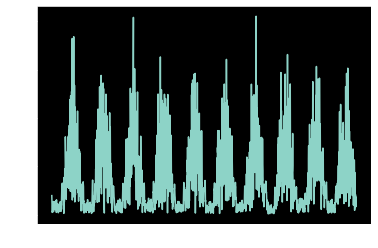

In [202]:
plt.plot(corr_vals)

In [234]:
def _determine_shift(corr_vals: list, shifts: list):
    argmax = np.argmax(corr_vals)
    return shifts[argmax]

_determine_shift(corr_vals, shifts)

def set_corr_threshold(corr_vals: list, scalar: float=0.6):
    threshold = np.max(corr_vals) * 0.60
    return threshold

threshold = set_corr_threshold(corr_vals, scalar=0.6)
threshold

def _find_first_peak(corr_vals: list, threshold: float):
    peaks = np.where(corr_vals > threshold)[0]
    logger.debug(f'found {len(peaks)} peaks [{peaks[0]}]')
    
    return peaks[0]

peak = _find_first_peak(corr_vals, threshold)
peak

def find_first_peak_shift(peak: int, shifts: list):
    return shifts[peak]

find_first_peak_shift(peak, shifts)

### original

In [164]:
corr_vals = np.real(np.abs(np.array([
    np.corrcoef(base_symbol.data, packet.data[shift:shift+signal.stats.samp_per_sym - 1])[0,1]
    for shift in shifts
])))

corr_vals

array([0.01957092, 0.01226302, 0.00561271, ..., 0.00808967, 0.01374691,
       0.01768555])

In [211]:
np.argmax(corr_vals), list(shifts)[np.argmax(corr_vals)]

(1342, 2684)

In [213]:
threshold = np.max(corr_vals) * 0.60
threshold

0.1232064406135476

In [214]:
np.where(corr_vals > threshold)[0][0]

130

In [215]:
list(shifts)[130]

260

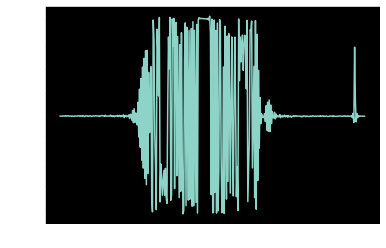

In [216]:
plt.plot(packet.data[260:260+signal.stats.samp_per_sym])

In [142]:
packet.endpoints

(14822825, 14834925)

In [144]:
260 + packet.endpoints[0]

14823085

## inspect

In [ ]:
packet = signal.random_packet
packet.plot()
display(packet) 

# symbols

In [ ]:
packet

## extraction

In [ ]:
packet.extract_preamble_symbols()

In [ ]:
packet.plot_symbol()

## inspection

In [ ]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

## convolution

### setup `.p` reference

In [ ]:
ploader = lorapy.load_dotp(OUTDOOR_DATA_DIR, autoload=True)
ploader.file_list

In [ ]:
pfile = ploader.select(1)
baseline = pfile.to_signal()
baseline.plot()
display(baseline)

## convolve

In [ ]:
symbol.convolve(baseline[0])

In [ ]:
baseline.plot(0)

## signal all together

In [ ]:
packet = signal.random_packet
packet.extract_preamble_symbols()

packet.plot()
display(packet)

In [ ]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

In [ ]:
symbol.convolve(baseline[562])

In [ ]:
symbol.absolute_endpoints

In [ ]:
signal.plot(real=False, start=symbol.absolute_endpoints[0], stop=symbol.absolute_endpoints[1])

In [ ]:
signal.stats.filename

## conv scratch

In [ ]:
baseline = baseline[0:signal.stats.samp_per_sym]

c_out = []

for i in range(symbols.shape[0]):
    sig = symbols[i,:]
    sig_c = np.conj(sig[::-1])
    conv_val = np.abs(np.convolve(baseline,sig_c))/np.linalg.norm(sig)/np.linalg.norm(sig)

    c_out.append(np.max(conv_val))

fig = plt.figure(figsize=(15,5))
plt.plot(c_out)